In [1]:
import os
import scipy.io as scio
import pandas as pd
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import numpy as np
import math
from skyfield.api import EarthSatellite,load, wgs84
from skyfield.elementslib import osculating_elements_of
from pytz import timezone
from matplotlib.colors import cnames
from tqdm import tqdm
from multiprocessing import Pool
import statsmodels.api as sm
from matplotlib.pyplot import MultipleLocator
from tqdm import  tqdm
UTC = timezone('UTC')


In [2]:
tlepath="./data/"
starttime=datetime.strptime("2022-5-14 0:0:0","%Y-%m-%d %H:%M:%S")
endtime=datetime.strptime("2022-5-26 0:0:0","%Y-%m-%d %H:%M:%S")
delta_time=(endtime-starttime).days*24*3600+(endtime-starttime).seconds
times=[starttime+timedelta(seconds=i) for i in range(0,delta_time,60)]
sat_list=[44767,47762]

In [3]:
data_based_on_updated_tle={}
epoch={}
altitude={}
for sat in tqdm(sat_list):
    heights=[]
    position=[]
    
    sattle=pd.read_csv(tlepath+str(sat)+'.csv')
    sattle['EPOCH']=sattle['EPOCH'].astype('datetime64[ns]')
    
    temp=sattle[(sattle['EPOCH']<starttime)]
    temp=temp.sort_values(by="EPOCH")
    begin_tle=temp.loc[temp.index[-1]]
    sattle=sattle[(sattle['EPOCH']>starttime-timedelta(days=1))&(sattle['EPOCH']<endtime+timedelta(days=1))]
    sattle=sattle.sort_values(by="EPOCH")
    altitude[sat]=list(sattle['SEMIMAJOR_AXIS']-6378)
    epoch[sat]=list(sattle['EPOCH'])
    sattle=sattle[(sattle['EPOCH']>starttime)&(sattle['EPOCH']<endtime)]
    sattle=sattle.drop_duplicates(subset=['EPOCH'])
    sattle=sattle.reset_index()
    ts = load.timescale()
    for i in range(sattle.shape[0]+1):
        if i==0:
            end_time=sattle.loc[sattle.index[i]]['EPOCH'].round('1min')
            Satellite = EarthSatellite(begin_tle['TLE_LINE1'], begin_tle['TLE_LINE2'], 'ISS (ZARYA)', ts)
            start_time=starttime
        elif i==sattle.shape[0]:
            start_time=sattle.loc[sattle.index[i-1]]['EPOCH'].round('1min')
            end_time=endtime
            Satellite = EarthSatellite(sattle.loc[sattle.index[i-1]]['TLE_LINE1'], sattle.loc[sattle.index[i-1]]['TLE_LINE2'], 'ISS (ZARYA)', ts)
        else:
            start_time=sattle.loc[sattle.index[i-1]]['EPOCH'].round('1min')
            end_time=sattle.loc[sattle.index[i]]['EPOCH'].round('1min')
            Satellite = EarthSatellite(sattle.loc[sattle.index[i-1]]['TLE_LINE1'], sattle.loc[sattle.index[i-1]]['TLE_LINE2'], 'ISS (ZARYA)', ts)
        delta_time=(end_time-start_time).seconds+(end_time-start_time).days*3600*24
        for seconds in range(0,delta_time,60):
            t=start_time+timedelta(seconds=seconds)
            t = UTC.localize(t)
            t_s = ts.from_datetime(t)
            geocentric = Satellite.at(t_s)
            oscu=osculating_elements_of(geocentric)
            height = wgs84.height_of(geocentric)
            heights.append(height.km)
            position.append(geocentric.position.km)
            #velocities.append(geocentric.velocity.km_per_s) # modified by zhaow
            # lat, lon = wgs84.latlon_of(geocentric)
            # lat_long.append([lat.degrees,lon.degrees])
    data_based_on_updated_tle[int(sat)]={}
    # data_based_on_updated_tle[int(sat)]['lat_long']=lat_long
    data_based_on_updated_tle[int(sat)]['height']=heights
    data_based_on_updated_tle[int(sat)]['position']=position
    # data_based_on_updated_tle[int(sat)]['velocity'] = velocities

100%|██████████| 2/2 [00:24<00:00, 12.35s/it]


In [4]:
distance=[]
position1=data_based_on_updated_tle[sat_list[0]]['position']
position2=data_based_on_updated_tle[sat_list[1]]['position']
for i in range(len(position1)):
    distance.append(math.sqrt((position1[i][0]-position2[i][0])**2+(position1[i][1]-position2[i][1])**2+(position1[i][2]-position2[i][2])**2))

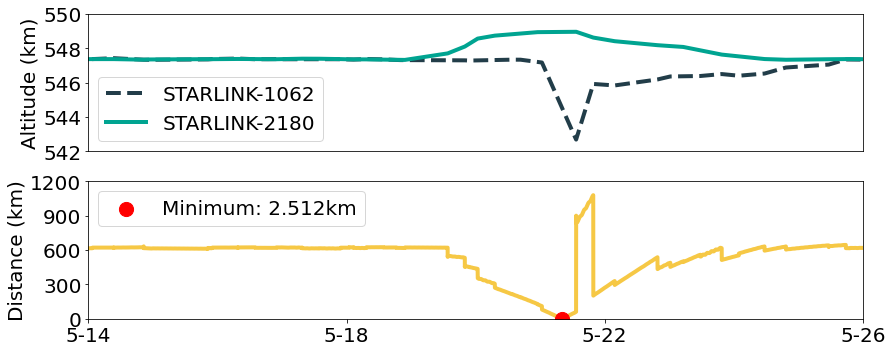

In [6]:
fig = plt.figure(figsize=(5*2.5, 5))
font3 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 19,
}
color=["#223d49","#00A491","#F6C845","#FF592D","#489DBC","#AE8CCD"]
ylabels = ["Altitude (km)", "Distance (km)"]
ls=['--','-']
label=['STARLINK-1062','STARLINK-2180']
plt.subplot(2, 1, 1)
plt.xlim(starttime, endtime)
plt.xticks([])

plt.ylim(542,550)
# plt.tick_params(labelsize=20)
plt.yticks(fontsize=20)
for i in range(len(sat_list)):
    xpoints = epoch[sat_list[i]]
    ypoints=altitude[sat_list[i]]
    # ypoints = data_based_on_updated_tle[sat_list[i]]['height']
        
    plt.plot(xpoints, ypoints, linewidth =4,c=color[i],ls=ls[i],label=label[i])
            
    # plt.title(titles[i], font = font3, loc = 'center')

    #plt.xlim(time_scale[0], time_scale[10])
    # plt.xlim(time_scale[0], time_scale[-1])
    #plt.xlabel('time (10 minute)', font3)
#             if i == 0:
#                 plt.title("STARLINK-" + sat, font = font3, loc = 'center')
    
plt.ylabel(ylabels[0], fontsize = 20)
plt.legend(fontsize=20)
    # plt.legend(loc=0)
# plt.xlabel('time', font3)          
#plt.savefig(sat + ".pdf",dpi=300,bbox_inches = 'tight')

# plt.subplots_adjust(wspace =0, hspace =0.2)#调整子图间距
plt.subplot(2, 1, 2)
plt.plot(times, distance, linewidth =4,c=color[2],zorder=1)
plt.scatter([starttime+timedelta(seconds=distance.index(min(distance))*60)], [min(distance)], s=200, c='r',label='Minimum: 2.512km',zorder=2)
plt.tick_params(labelsize=20)
plt.ylim(0,1200)
# plt.scatter([starttime+timedelta(seconds=distance.index(min(distance))*3600)], [min(distance)], s=200, c='r')
plt.yticks(range(0,1201,300),range(0,1201,300),fontsize=20)
plt.ylabel(ylabels[1], fontsize = 20)
plt.xlim(starttime, endtime)
plt.xticks([starttime,starttime+timedelta(days=4),starttime+timedelta(days=8),starttime+timedelta(days=12)],['5-14','5-18','5-22','5-26'],fontsize=20)
plt.legend(fontsize=20,loc='upper left')
plt.tight_layout() 
plt.savefig('figure24.png')

In [64]:
starttime+timedelta(seconds=distance.index(min(distance))*60)

datetime.datetime(2022, 5, 21, 8, 9)

In [77]:
min(distance)

2.5123705756544648